# DJI Drone Classification

### Objective: Create a image classifier to classify images of DJI drones (Phantom, Mavric and Inspire) using FastAI vision library and deploy it onto binder.

In [20]:
#Step 1: Import the necessary FASTAI libraries
from fastbook import *
from fastai.imports import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
#os.mkdir('drone-images')

In [21]:
#Step 2: Get the images of DJI Phantom, Mavric and Inspire via webscrapping from Bing Search
key = os.environ.get('AZURE_SEARCH_KEY','c4474757f65249b0a316565721d0c2f2')

# Define the drone types
drone_types = 'DJI Phantom','DJI Mavric','DJI Inspire'

# Define the path we are going to store the drone images
path = Path('drones')

In [23]:
# Check if directory/folder exist in the path, else create one
if not path.exists():
    path.mkdir()
    
    # for each drone type in the drone_types list, create a destinateion folder to stores the images for each category
    for d in drone_types:
        dest = (path/d)
        dest.mkdir(exist_ok=True)
        
        # using bing search api, search images of each type of drone category
        results = search_images_bing(key,f'{d} drone')
        
        # download the images from the url to the respective destination
        download_images(dest,urls=results.attrgot('content_url'))


 Download of http://venturebeat.com/wp-content/uploads/2015/04/p3_4K_RGB_009.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p drones/DJI Phantom
$ cd drones/DJI Phantom
$ wget -c http://venturebeat.com/wp-content/uploads/2015/04/p3_4K_RGB_009.jpg
$ tar xf p3_4K_RGB_009.jpg
 And re-run your code once the download is successful



In [28]:
# To check the filenames we have downloads
fns = get_image_files(path)
fns

(#423) [Path('drones/DJI Phantom/00000000.jpg'),Path('drones/DJI Phantom/00000002.png'),Path('drones/DJI Phantom/00000006.jpg'),Path('drones/DJI Phantom/00000003.jpg'),Path('drones/DJI Phantom/00000011.jpg'),Path('drones/DJI Phantom/00000010.jpg'),Path('drones/DJI Phantom/00000005.png'),Path('drones/DJI Phantom/00000007.png'),Path('drones/DJI Phantom/00000012.jpg'),Path('drones/DJI Phantom/00000013.jpg')...]

In [27]:
# To check if any of the downloaded files are not images, if so unlink (delete) them
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [30]:
# Step 3: Load the data onto dataloaders

drone = DataBlock(blocks=(ImageBlock,CategoryBlock),get_items=get_image_files,
                 splitter = RandomSplitter(valid_pct=0.3,seed=42),get_y=parent_label,
                 item_tfms=Resize(128))

dls = drone.dataloaders(path)

In [38]:
# Step 4: Training model using the resnet archietecture with 18 layers

learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.899829,0.834326,0.285714,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.905274,0.578414,0.230159,00:07
1,0.708577,0.469486,0.142857,00:07
2,0.549893,0.456671,0.166667,00:07
3,0.465149,0.459289,0.166667,00:07
4,0.389275,0.470134,0.174603,00:07


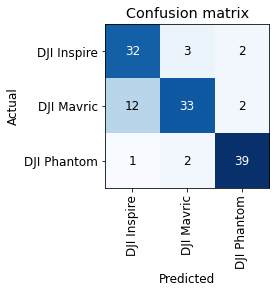

In [40]:
# Step 5: Looking at how well the model perform

inter = ClassificationInterpretation.from_learner(learn)
inter.plot_confusion_matrix()

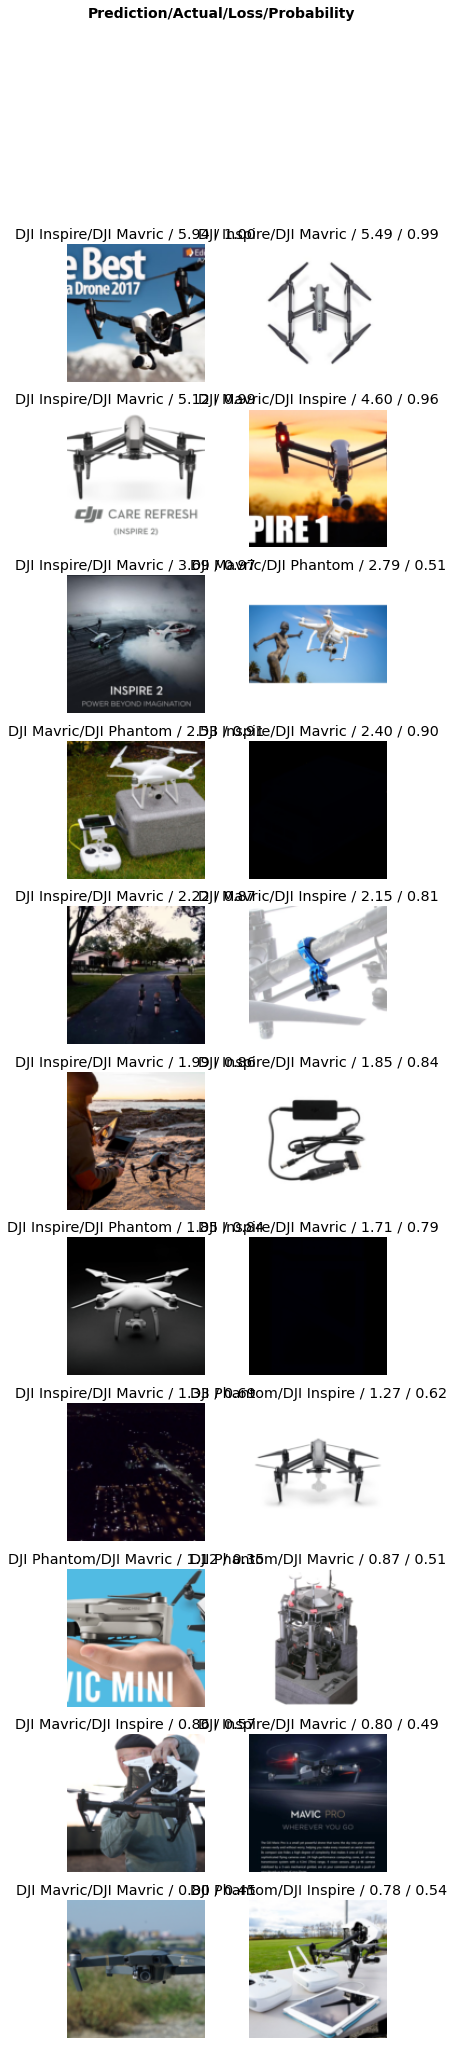

In [45]:
inter.plot_top_losses(22,nrows=11)

In [46]:
# Step 6: Performing data cleaning

cleaner = ImageClassifierCleaner(learn)
cleaner

In [47]:
# delete those images that we selected as to delete
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# change the category of those images we selected to change
for idx in cleaner.change():
    shutil.move(str(cleaner.fns[idx]),path/cat)

In [49]:
# Step 7: Retrain our model again
learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.031757,0.974713,0.341270,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.080428,0.551079,0.214286,00:07
1,0.855551,0.430352,0.134921,00:07
2,0.687878,0.395949,0.095238,00:07
3,0.545327,0.427304,0.126984,00:06
4,0.462321,0.450371,0.126984,00:06


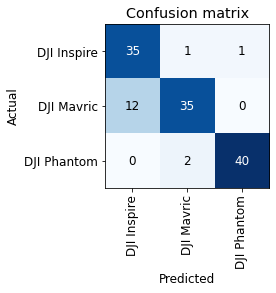

In [50]:
inter = ClassificationInterpretation.from_learner(learn)
inter.plot_confusion_matrix()

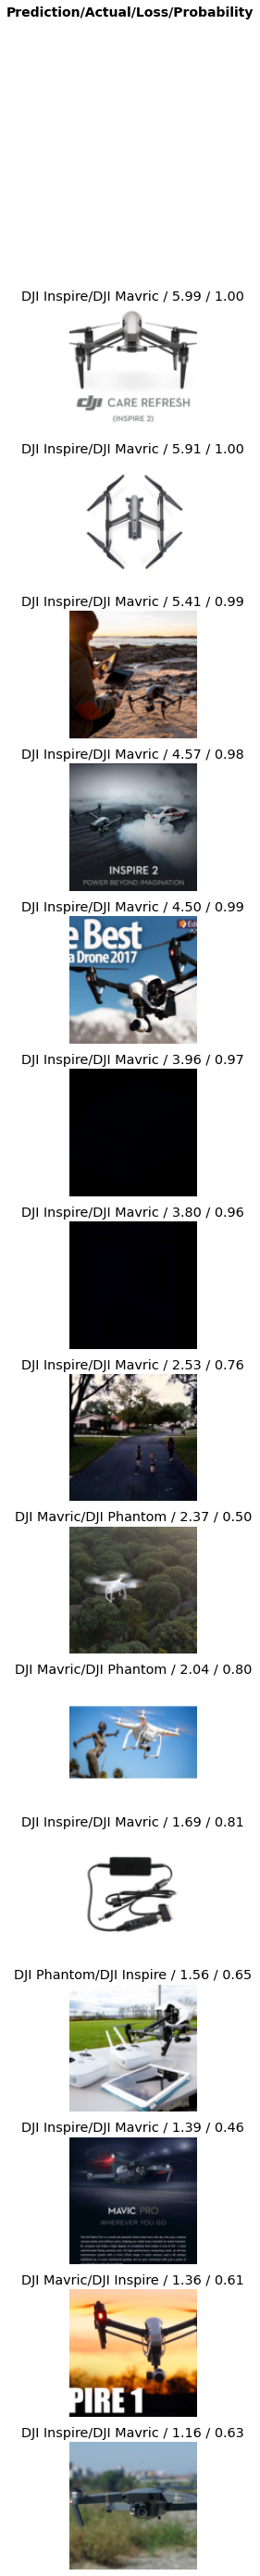

In [51]:
inter.plot_top_losses(15,nrows=15)

In [52]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [53]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]),path/cat)

In [54]:
learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.645612,0.780182,0.317460,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.849642,0.461573,0.182540,00:07
1,0.675089,0.406602,0.142857,00:06
2,0.545028,0.417277,0.142857,00:06
3,0.437276,0.417746,0.126984,00:06
4,0.363747,0.409150,0.150794,00:07


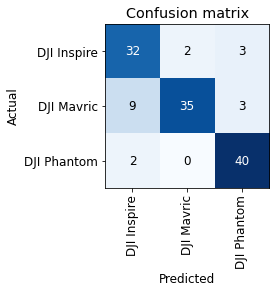

In [55]:
inter = ClassificationInterpretation.from_learner(learn)
inter.plot_confusion_matrix()

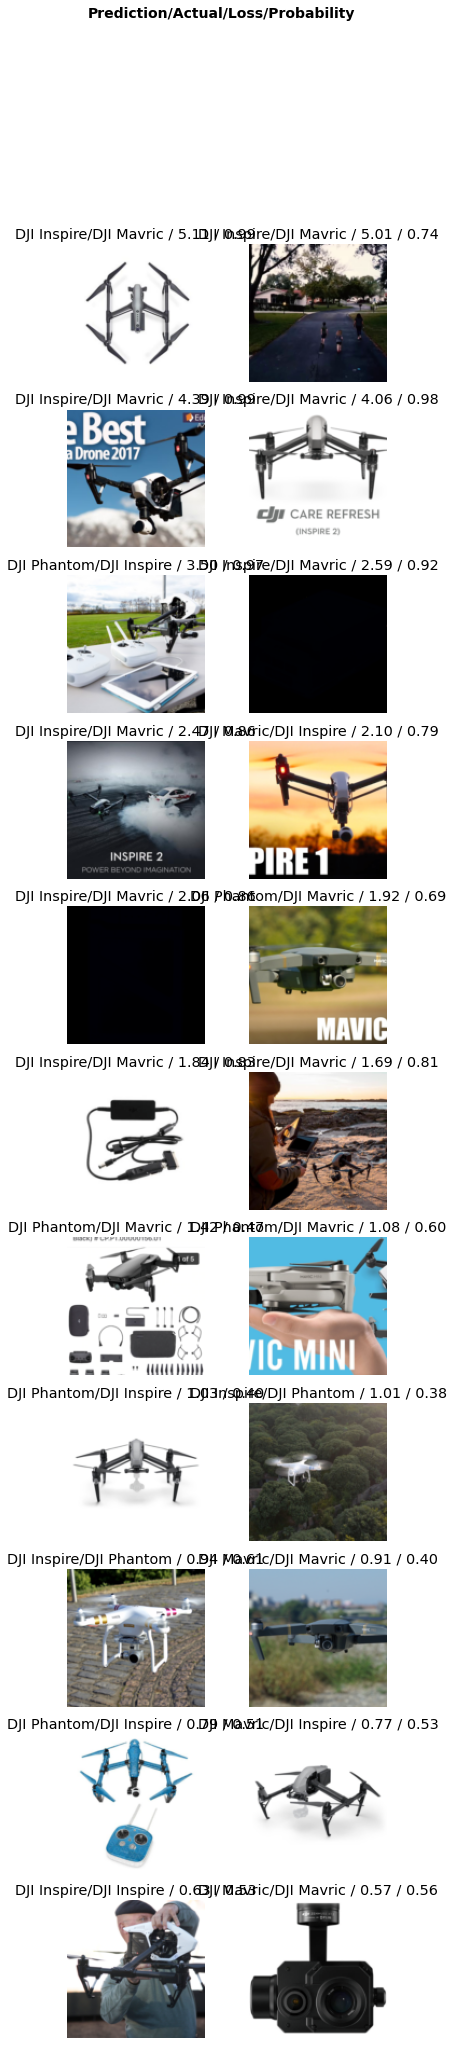

In [56]:
inter.plot_top_losses(22,nrows=11)

In [57]:
# Step 8: Exporting our model
learn.export()

In [58]:
# checking if the model has been exported successfully
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [65]:
# Step 9: Creating a Notebook App from the Model

# Loading our model
learn_inf = load_learner(path/'export.pkl')

# Creating a file upload widget
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [67]:
# Grabbing and using the uploaded image
img = PILImage.create(btn_upload.data[-1])

In [68]:
# Using an output widget to display the image
out_pl=widgets.Output()
out_pl.clear_output()

with out_pl:
    display(img.to_thumb(128,128))

out_pl

Output()

In [70]:
# Getting out the predictions values
pred,pred_idx,probs = learn_inf.predict(img)

In [76]:
# Use Label to display the results
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: DJI Mavric; Probability: 0.9999')

In [81]:
# Create a widget button for the user to press to run the image through the model
btn_run = widgets.Button(description='Classify')
btn_run

# Map the actions to the button
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [82]:
# Package everything into a vertical box to complete our GUI
VBox([widgets.Label('DJI Drone Classifier'),btn_upload,btn_run,out_pl,lbl_pred])

In [83]:
# Installing viola if it has not yet been installed
!pip install viola
!jupyter serverextension enable viola --sys-prefix

Enabling: viola
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      X is viola importable?
